Part I: A photo booth application

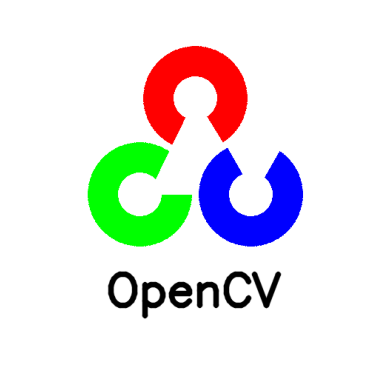

In [1]:
import cv2
import numpy as np

img = np.zeros((500, 500, 3), dtype=np.uint8) 

img[:] = (255,255,255) 

triangle = np.array([[250, 120], [187, 250], [330, 250]], np.int32)
triangle_inverted = np.array([[290, 180], [370, 180], [330, 250]], np.int32)

#positioning
red_arc = (250, 120)
green_arc = (175, 250)
blue_arc = (325, 250)

radius = 50
thickness = 40

#Red arc
cv2.circle(img, red_arc, radius, (0, 0, 255), thickness)
#Green arc
cv2.circle(img, green_arc, radius, (0, 255, 0), thickness)
#Center triangle
cv2.fillPoly(img, [triangle], (255,255,255))
#Blue arc
cv2.circle(img, blue_arc, radius, (255, 0, 0), thickness)
#Inverted triangle
cv2.fillPoly(img, [triangle_inverted], (255, 255, 255))

#OpenCV text
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, "OpenCV", (130, 400), font, 2, (0, 0, 0), 6, cv2.LINE_AA)

#Display using opencv
cv2.imshow("OpenCV logo", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("opencv_logo.png", img)

import matplotlib.pyplot as plt

#inline display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.show()


Part II: Image Arithmetic

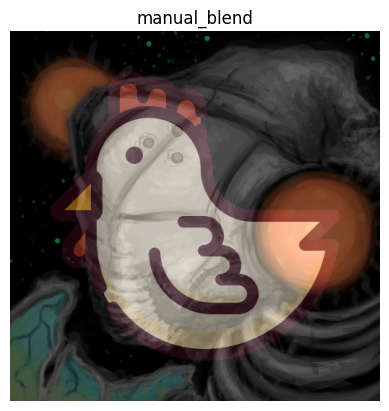

In [3]:
import cv2
import numpy as np

img1 = cv2.imread('cicada.jpg')
img2 = cv2.imread('chicken1.jpg')

fixed_size = (512, 512)
img1 = cv2.resize(img1, fixed_size)
img2 = cv2.resize(img2, fixed_size)

# Blend factor between 0 and 1
alpha = 0.5  

# Manual blending using numpy
blend = ((1 - alpha) * img1.astype(np.float32) + alpha * img2.astype(np.float32)).astype(np.uint8)

cv2.imwrite("manual_blend.jpg", blend)
cv2.imshow("manual_blend", blend)
cv2.waitKey(0)
cv2.destroyAllWindows()

#inline display
import matplotlib.pyplot as plt

blend_rgb = cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)

plt.imshow(blend_rgb)
plt.title("manual_blend")
plt.axis("off")
plt.show()

Part II: Image Arithmetic

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox
from IPython.display import display, clear_output

history_stack = []
history_log = []
current_image = None
output_area = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        height='auto',
        overflow='hidden',
        padding='0px',
        border='none'
    )
)

# functions
def show_images(before, after=None, title1="Original", title2="Edited"):
    with output_area:
        clear_output(wait=True)

        if after is None:
            fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
            ax.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
            ax.set_title(title1)
            ax.axis("off")
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
            ax1.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
            ax1.set_title(title1)
            ax1.axis("off")
            ax2.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
            ax2.set_title(title2)
            ax2.axis("off")

        fig.patch.set_facecolor('white')
        for ax in fig.axes:
            ax.set_position([0, 0, 1, 1])
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

def push_state(action):
    global current_image
    history_stack.append(current_image.copy())
    history_log.append(action)

def apply_padding(pad, border_type, aspect_choice="Square"):
    global current_image
    h, w = current_image.shape[:2]
    border_dict = {
        "constant": cv2.BORDER_CONSTANT,
        "reflect": cv2.BORDER_REFLECT,
        "replicate": cv2.BORDER_REPLICATE
    }
    btype = border_dict.get(border_type, cv2.BORDER_CONSTANT)
    color = [0, 0, 0] if border_type == "constant" else None

    # Make it square first by padding one dimension
    if aspect_choice == "Square":
        if w > h:
            pad_h = (w - h) // 2
            top = pad_h
            bottom = (w - h) - pad_h
            left = right = 0
        else:
            pad_w = (h - w) // 2
            left = pad_w
            right = (h - w) - pad_w
            top = bottom = 0
        img = cv2.copyMakeBorder(current_image, top, bottom, left, right, btype, value=color if color else [255, 255, 255])
        # Then apply the user padding all around
        img = cv2.copyMakeBorder(img, pad, pad, pad, pad, btype, value=color if color else [255, 255, 255])
        show_images(current_image, img)
        push_state(f"padding square + {pad}px {border_type}")
        current_image = img
        return

    # Other fixed ratios
    elif aspect_choice in ["16:9", "4:5", "3:2", "5:7"]:
        ratio_map = {
            "16:9": 16 / 9,
            "4:5": 4 / 5,
            "3:2": 3 / 2,
            "5:7": 5 / 7
        }
        target_ratio = ratio_map[aspect_choice]
        new_w, new_h = w, h
        if w / h < target_ratio:
            new_w = int(h * target_ratio)
        else:
            new_h = int(w / target_ratio)
        pad_w = (new_w - w) // 2
        pad_h = (new_h - h) // 2
        left = pad_w
        right = (new_w - w) - pad_w
        top = pad_h
        bottom = (new_h - h) - pad_h
    else:
        # Default behavior for "Custom"
        top = bottom = left = right = pad

    img = cv2.copyMakeBorder(current_image, top, bottom, left, right, btype, value=color if color else [255, 255, 255])
    show_images(current_image, img)
    push_state(f"padding {pad}px {border_type} {aspect_choice}")
    current_image = img

def show_padding_controls():
    pad = widgets.IntSlider(min=0, max=200, step=10, value=20, description="Padding")
    border = widgets.Dropdown(options=["constant", "reflect", "replicate"], description="Border")
    aspect = widgets.Dropdown(options=["Square", "16:9", "4:5", "3:2", "5:7"], description="Proportion")
    btn = widgets.Button(description="Apply")
    btn.on_click(lambda b: apply_padding(pad.value, border.value, aspect.value))
    display(VBox([pad, border, aspect, btn]))

def load_image_widget():
    uploader = widgets.FileUpload(accept='image/*', multiple=False)
    display(uploader)

    def on_upload_change(change):
        global current_image
        if uploader.value:
            uploaded_file = uploader.value[0]
            content = uploaded_file['content']
            file_bytes = np.frombuffer(content, dtype=np.uint8)
            img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
            if img is not None:
                history_stack.clear()
                history_log.clear()
                history_stack.append(img.copy())
                current_image = img.copy()
                show_images(current_image)
            else:
                print("Failed to decode image.")
        uploader.unobserve(on_upload_change, names='value')

    uploader.observe(on_upload_change, names='value')

def convert_grayscale():
    global current_image
    img = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    show_images(current_image, img, "Original", "Edited")
    push_state("grayscale")
    current_image = img

def adjust_brightness(val):
    global current_image
    img = cv2.convertScaleAbs(current_image, beta=val)
    show_images(current_image, img)
    push_state(f"brightness {val}")
    current_image = img

def adjust_contrast(val):
    global current_image
    img = current_image.astype(np.float32)
    factor = 1 + (val / 100.0)  # val can be -100 to 100

    # Shift pixel range around 128 (midtone), apply contrast, then shift back
    img = (img - 128) * factor + 128
    img = np.clip(img, 0, 255).astype(np.uint8)

    show_images(current_image, img)
    push_state(f"contrast {val}")
    current_image = img

def apply_threshold(thresh_type, value):
    global current_image
    gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
    ttype = cv2.THRESH_BINARY if thresh_type == "binary" else cv2.THRESH_BINARY_INV
    _, img = cv2.threshold(gray, value, 255, ttype)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    show_images(current_image, img)
    push_state(f"threshold {thresh_type} {value}")
    current_image = img

def blend_with_widget():
    uploader = widgets.FileUpload(accept='image/*', multiple=False)
    alpha = widgets.FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, description="Alpha")
    display(VBox([alpha, uploader]))

    def on_blend_upload_change(change):
        global current_image
        uploaded_file = uploader.value[0]
        content = uploaded_file['content']
        file_bytes = np.frombuffer(content, dtype=np.uint8)
        img2 = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        if img2 is not None:
            img2 = cv2.resize(img2, (current_image.shape[1], current_image.shape[0]))
            blended = ((1 - alpha.value) * current_image + alpha.value * img2).astype(np.uint8)
            show_images(current_image, blended)
            push_state(f"blend {alpha.value}")
            current_image = blended
        else:
            print("Failed to decode second image.")
        uploader.unobserve(on_blend_upload_change, names='value')

    uploader.observe(on_blend_upload_change, names='value')

def undo():
    global current_image
    if len(history_stack) > 1:
        history_stack.pop()
        current_image = history_stack[-1].copy()
        show_images(current_image, current_image, "Undo", "Undo")
        history_log.append("undo")
    else:
        print("Nothing to undo.")

def view_history():
    with output_area:
        clear_output(wait=True)
        print("\n--- Operation History ---")
        for i, entry in enumerate(history_log, 1):
            print(f"{i}. {entry}")
        print("-------------------------\n")

def save_image_widget():
    path = widgets.Text(description="Filename:", placeholder="example.png")
    btn = widgets.Button(description="Save Image")

    def on_click(b):
        filename = path.value.strip()
        if not filename.endswith((".png", ".jpg", ".jpeg")):
            filename += ".png"
        cv2.imwrite(filename, current_image)
        print(f"Image saved as {filename}")

    btn.on_click(on_click)
    display(VBox([path, btn]))

def show_brightness_controls():
    slider = widgets.IntSlider(min=-100, max=100, step=10, value=0, description="Brightness")
    btn = widgets.Button(description="Apply")
    btn.on_click(lambda b: adjust_brightness(slider.value))
    display(VBox([slider, btn]))

def show_contrast_controls():
    slider = widgets.IntSlider(min=-100, max=100, step=10, value=0, description="Contrast")
    btn = widgets.Button(description="Apply")
    btn.on_click(lambda b: adjust_contrast(slider.value))
    display(VBox([slider, btn]))

def show_threshold_controls():
    method = widgets.Dropdown(options=["binary", "inverse"], value="binary", description="Type")
    thresh = widgets.IntSlider(min=0, max=255, step=10, value=127, description="Threshold")
    btn = widgets.Button(description="Apply")
    btn.on_click(lambda b: apply_threshold(method.value, thresh.value))
    display(VBox([method, thresh, btn]))

def show_menu():
    btn_load = widgets.Button(description="Load Image")
    btn_brightness = widgets.Button(description="Adjust Brightness")
    btn_contrast = widgets.Button(description="Adjust Contrast")
    btn_grayscale = widgets.Button(description="Convert to Grayscale")
    btn_padding = widgets.Button(description="Add Padding")
    btn_threshold = widgets.Button(description="Apply Thresholding")
    btn_blend = widgets.Button(description="Blend with Another Image")
    btn_undo = widgets.Button(description="Undo Last Operation")
    btn_history = widgets.Button(description="View History of Operations")
    btn_save = widgets.Button(description="Save and Exit")

    # Define button actions
    btn_load.on_click(lambda b: _wrap(load_image_widget))
    btn_brightness.on_click(lambda b: _wrap(show_brightness_controls))
    btn_contrast.on_click(lambda b: _wrap(show_contrast_controls))
    btn_grayscale.on_click(lambda b: _wrap(convert_grayscale))
    btn_padding.on_click(lambda b: _wrap(show_padding_controls))
    btn_threshold.on_click(lambda b: _wrap(show_threshold_controls))
    btn_blend.on_click(lambda b: _wrap(blend_with_widget))
    btn_undo.on_click(lambda b: _wrap(undo))
    btn_history.on_click(lambda b: _wrap(view_history))
    btn_save.on_click(lambda b: _wrap(save_image_widget))

    # Display the buttons and output area
    button_box = VBox([
        btn_load, btn_brightness, btn_contrast, btn_grayscale,
        btn_padding, btn_threshold, btn_blend, btn_undo,
        btn_history, btn_save
    ])
    display(HBox([button_box, output_area]))


# Helper to clear output and run function
def _wrap(fn):
    output_area.clear_output()
    with output_area:
        fn()

In [5]:
show_menu()